In [1]:
import numpy as np
import random
import itertools
import math
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date, timedelta
import time
from gga import GGA

In [2]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])
aapl['Date'] = pd.to_datetime(aapl['Date'])
aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [12]:
#  """Based on parameter setting adopted in Chen et al (2021) """

def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1_CONDITIONS':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2_CONDITIONS':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3_CONDITIONS':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4_CONDITIONS':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5_CONDITIONS': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6_CONDITIONS': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7_CONDITIONS': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8_CONDITIONS': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies
data, strategies =generate_candidate_trading_signals(aapl.copy())

In [13]:
def get_last_date_of_month(year, month):
    """Return the last date of the month.
    
    Args:
        year (int): Year, i.e. 2022
        month (int): Month, i.e. 1 for January

    Returns:
        date (datetime): Last date of the current month
    """
    
    if month == 12:
        last_date = datetime(year, month, 31)
    else:
        last_date = datetime(year, month + 1, 1) + timedelta(days=-1)
    
    return last_date


def binary_to_sltp(sltp,n,b,sl_boundary,tp_boundary):
    """CONVERT SLPT Part to float"""
    
    sl_part,tp_part = sltp[:n],sltp[n:]
    max_sl = sum([np.power(2,i)*1 for i in range(len(sl_part))])
    max_tp = sum([np.power(2,i)*1 for i in range(len(tp_part))])
    sl_part.reverse()
    tp_part.reverse()
    sl  = sum([np.power(2,i)*sl_part[i] for i in range(len(sl_part))])
    tp  = sum([np.power(2,i)*tp_part[i] for i in range(len(tp_part))])
    sl = sl_boundary/max_sl * sl
    tp = tp_boundary/max_tp * tp
    return sl,tp

def generate_trading_signal(data,strategy,stop_loss,take_profit):
    monthly_returns = []
    monthly_return = 0
    trade_freq = 0
    monthly_freq = 0
    market_position = 'out'
    max_loss = 0
    for row in data.itertuples(index=False):    
        #close all trade positions at month end. 
        last_date = get_last_date_of_month(row.Date.year,row.Date.month)
        if row.Date == last_date :
            if market_position =='in':
                sell_price = row.close
                trade_return = (sell_price - cost_price)/cost_price
                market_position = 'out' 
                trade_freq +=1
                monthly_freq +=1
                monthly_return += trade_return
                avg_monthly_return =monthly_return/monthly_freq
                monthly_returns.append(avg_monthly_return)
                monthly_return = 0
                monthly_freq = 0       
            else:
                try:
                    avg_monthly_return = monthly_return/monthly_freq
                except ZeroDivisionError:
                    avg_monthly_return = 1
                monthly_returns.append(avg_monthly_return)
            
                monthly_return = 0
                monthly_freq = 0         
        else:
            if market_position == 'out' :
                if row[data.columns.get_loc(strategy)] == 1:
                    cost_price = row.close
                    market_position = 'in'
                    
            else:
                sell_price = row.close
                trade_return = (sell_price - cost_price)/cost_price
                if trade_return <= stop_loss or trade_return >= take_profit: 
                    trade_freq +=1
                    monthly_freq+=1
                    if trade_return < max_loss:
                        max_loss = trade_return
                    monthly_return += trade_return
                    market_position = 'out'   
                    
                if row[data.columns.get_loc(strategy)] == 0 and trade_return >= take_profit :
                    trade_freq +=1
                    monthly_freq+=1
                    if trade_return < max_loss:
                        max_loss = trade_return
                    monthly_return += trade_return
                    market_position = 'out'
    avg_return = np.mean(monthly_returns)
    strategy_performance ={"returns":monthly_returns}
    return monthly_returns

def strategy_performance(data,strategies,sltp,n,b,stop_loss,take_profit):
    sl, tp = binary_to_sltp(sltp,n,b,stop_loss,take_profit)
    strategy_performance = {}
    for strategy in strategies:
        strategy_performance[strategy] = generate_trading_signal(data,strategy,sl,tp)
        
    strategy_performance = pd.DataFrame.from_dict(strategy_performance)
    return strategy_performance


In [5]:

# generate maxdraw down
def generateMDD(data,strategy,stop_loss,take_profit):
    monthly_returns = []
    monthly_return = 0
    trade_freq = 0
    monthly_freq = 0
    market_position = 'out'
    max_loss = 0
    for row in data.itertuples(index=False):    
        #close all trade positions at month end. 
        last_date = get_last_date_of_month(row.Date.year,row.Date.month)
        if row.Date == last_date :
            if market_position =='in':
                sell_price = row.close
                trade_return = (sell_price - cost_price)/cost_price
                if trade_return < max_loss:
                        max_loss = trade_return
                market_position = 'out' 
                trade_freq +=1
                monthly_freq +=1
                monthly_return += trade_return
                avg_monthly_return =monthly_return/monthly_freq
                monthly_returns.append(avg_monthly_return)
                monthly_return = 0
                monthly_freq = 0       
            else:
                try:
                    avg_monthly_return = monthly_return/monthly_freq
                except ZeroDivisionError:
                    avg_monthly_return = 1
                monthly_returns.append(avg_monthly_return)
            
                monthly_return = 0
                monthly_freq = 0         
        else:
            if market_position == 'out' :
                if row[data.columns.get_loc(strategy)] == 1:
                    cost_price = row.close
                    market_position = 'in'
                    
            else:
                sell_price = row.close
                trade_return = (sell_price - cost_price)/cost_price
                if trade_return <= stop_loss or trade_return >= take_profit: 
                    trade_freq +=1
                    monthly_freq+=1
                    if trade_return < max_loss:
                        max_loss = trade_return
                    monthly_return += trade_return
                    market_position = 'out'   
                    
                if row[data.columns.get_loc(strategy)] == 0 and trade_return >= take_profit :
                    trade_freq +=1
                    monthly_freq+=1
                    if trade_return < max_loss:
                        max_loss = trade_return
                    monthly_return += trade_return
                    market_position = 'out'
   
 
    return max_loss

def strategy_mdd(data,strategies,sltp,n,b,stop_loss,take_profit):
    sl, tp = binary_to_sltp(sltp,n,b,stop_loss,take_profit)
    strategy_performance = {}
    for strategy in strategies:
        strategy_performance[strategy] = generateMDD(data,strategy,sl,tp)
        
    
    return strategy_performance


In [19]:
popu= init_population(5,4,4,3,9,strategies)
for  i in popu:
    print(i)

[[1, 1, 0, 0, 0, 0, 0, 0], [['TS5_CONDITIONS'], ['TS1_CONDITIONS'], ['TS8_CONDITIONS', 'TS3_CONDITIONS', 'TS7_CONDITIONS', 'TS2_CONDITIONS', 'TS4_CONDITIONS', 'TS6_CONDITIONS']], [1, 0, 0, 0, 1, 1, 1, 1, 1], 1]
[[1, 0, 0, 1, 0, 1, 1, 1], [[], ['TS4_CONDITIONS', 'TS1_CONDITIONS', 'TS3_CONDITIONS', 'TS6_CONDITIONS', 'TS7_CONDITIONS'], ['TS8_CONDITIONS', 'TS2_CONDITIONS', 'TS5_CONDITIONS']], [0, 0, 0, 1, 1, 1, 1, 1, 1], 1]
[[1, 1, 1, 0, 1, 1, 1, 0], [['TS6_CONDITIONS', 'TS8_CONDITIONS', 'TS3_CONDITIONS'], ['TS1_CONDITIONS', 'TS5_CONDITIONS', 'TS4_CONDITIONS'], ['TS2_CONDITIONS', 'TS7_CONDITIONS']], [1, 0, 0, 0, 1, 1, 1, 1, 1], 1]
[[1, 1, 1, 1, 1, 0, 1, 1], [['TS3_CONDITIONS'], ['TS4_CONDITIONS', 'TS6_CONDITIONS', 'TS1_CONDITIONS', 'TS7_CONDITIONS', 'TS8_CONDITIONS'], ['TS5_CONDITIONS', 'TS2_CONDITIONS']], [0, 0, 0, 0, 1, 1, 1, 1, 1], 1]
[[1, 0, 0, 0, 1, 1, 1, 1], [['TS7_CONDITIONS', 'TS3_CONDITIONS', 'TS2_CONDITIONS'], ['TS6_CONDITIONS', 'TS8_CONDITIONS', 'TS5_CONDITIONS', 'TS1_CONDITIONS

In [459]:
data, strategies =generate_candidate_trading_signals(aapl.copy())

ts_data= strategy_performance(data,strategies,[1,1,1,1,0,0,1,1],4,4,-0.15,0.90)
MDD_data= strategy_mdd(data,strategies,[1,1,1,1,0,0,1,1],4,4,-0.15,0.90)
chromosome = popu[0]
weights = getWeights(chromosome[2],3)
w = chromosome[2]
L = sum([i for i in w if i == 1])
for i in weights:
    try:
        weights[i]= round(len(weights[i])/L,2)
    except ZeroDivisionError:
        weights[i] = 0
weights_df = pd.DataFrame([weights])
weights_df = weights_df.drop(0,axis=1)
total = 0
combs = list(itertools.product(*chromosome[1]))
for ts in  combs:
    tsp = ts_data[list(ts)].corr()
    tsp_var = np.linalg.multi_dot([weights_df.to_numpy(),tsp.to_numpy(),weights_df.to_numpy().T])
    total += tsp_var





In [14]:
# init population    
   
def generateSLTP(n,b):
    """Generate bits for SLTP Part"""
    l = n + b
    sltp= [random.randint(0, 1) for _ in range(l)]
    
    return sltp

def binary_to_sltp(sltp,n,b,sl_boundary,tp_boundary):
    """CONVERT SLPT Part to float"""
    
    sl_part,tp_part = sltp[:n],sltp[n:]
    max_sl = sum([np.power(2,i)*1 for i in range(len(sl_part))])
    max_tp = sum([np.power(2,i)*1 for i in range(len(tp_part))])
    sl_part.reverse()
    tp_part.reverse()
    sl  = sum([np.power(2,i)*sl_part[i] for i in range(len(sl_part))])
    tp  = sum([np.power(2,i)*tp_part[i] for i in range(len(tp_part))])
    sl = sl_boundary/max_sl * sl
    tp = tp_boundary/max_tp * tp
    return sl,tp


def generateGroup(K,strategies):
    """Generate Group and assign TS to groups K"""
    x = strategies.copy()
    random.shuffle(x)
    groups = [[] for k in range(K)]
    while x:
        s = x.pop()
        random_index = random.randrange(K)
        groups[random_index].append(s)
    return groups

def generateWeight(K,num_weight):
    """Generate Weight Part and assign to groups K"""
    weights= [1 for _ in range(num_weight)]
    K = K+1
    for i in range(K):
        random_index = random.randrange(K)
        weights[random_index] = 0
    return weights

def init_population(pSize,n,b,K,num_weight,strategies):
    population =[]
    for i in range(pSize):
        chromosome = [] #c = [[SLTP],[[K],[Weight]]
        chromosome.append(generateSLTP(n,b)) #SLPT PART
        chromosome.append(generateGroup(K,strategies)) # TS & Group Part"
        chromosome.append(generateWeight(K,num_weight)) #Weight Part
        chromosome.append(1) #fitness
        population.append(chromosome)
    
    return population





In [7]:
 #Fitness Function
    
def get_max_min(p4mc):
    modified ={}
    for i in  p4mc:
        modified[i] = p4mc[i]
    max_key= max(modified, key=modified.get)
    min_key = min(modified, key=modified.get)
    
    return modified[max_key], modified[min_key]



    
def getRisk(p4mc,chromosome):
    all_tsp = 0
    for i in range(len(chromosome[1])):
        
        tsp =[]
        for j in chromosome[1][i]:
            tsp.append(p4mc[j]['mdd'])
        if tsp:
            mdd = min(tsp)
        else:
            mdd =0
        all_tsp += mdd
    all_tsp = all_tsp/len(chromosome[1])
    return all_tsp

def normalisation_mdd(p4mc):
    max_value,min_value = get_max_min(p4mc)
    for i in p4mc:
        p4mc[i] = (p4mc[i] - min_value )/ (max_value - min_value)
    return p4mc
    
def getMDD(p4mc,chromosome):
    all_tsp = 0
    for i in range(len(chromosome[1])):
        
        tsp =[]
        for j in chromosome[1][i]:
            minn = p4mc[j]
            tsp.append(minn)
        try:
            mdd = min(tsp)
        except:
            mdd =0
        all_tsp += mdd
    all_tsp = all_tsp/len(chromosome[1])
    return all_tsp

def normalisation(trading_strategies_data):
    normalised_ts_data = trading_strategies_data.copy()
    for ts in trading_strategies_data.columns:
        max_value = trading_strategies_data[ts].max()
        min_value = trading_strategies_data[ts].min()
        normalised_ts_data[ts] = (trading_strategies_data[ts] - min_value) / (max_value - min_value)
    return normalised_ts_data

def getWeights(weightPart,K):
    w = weightPart.copy()
    L = sum([i for i in w if i == 1])
    K = K+1
    z = {k: [] for k in range(K)}
    for i in range(K):
        while w:
                x = w.pop(0)
                if x == 0:
                    break
                else:

                    z[i].append(x)
    
    return z
    


def getProfit(p4mc,chromosome,allocated_capital,K):
    weights = getWeights(chromosome[2],K)
    w = chromosome[2]
    L = sum([i for i in w if i == 1])
    for i in weights:
        try:
            weights[i]= round(len(weights[i])/L,2)
        except ZeroDivisionError:
            weights[i] = 0
    total = 0
    for i in range(len(chromosome[1])):
        for j in chromosome[1][i]:
            avg_return = p4mc[j].mean()
            total += avg_return*weights[i+1]*allocated_capital
    return total


    
def getCorrelation(ts_data,chromosome,K):
    weights = getWeights(chromosome[2],K)
    w = chromosome[2]
    L = sum([i for i in w if i == 1])
    for i in weights:
        try:
            weights[i]= round(len(weights[i])/L,2)
        except ZeroDivisionError:
            weights[i] = 0
    weights_df = pd.DataFrame([weights])
    weights_df = weights_df.drop(0,axis=1)
    total = 0
    combs = list(itertools.product(*chromosome[1]))
    for ts in  combs:
        tsp = ts_data[list(ts)].corr()
        tsp_var = np.linalg.multi_dot([weights_df.to_numpy(),tsp.to_numpy(),weights_df.to_numpy().T])
        total += tsp_var
    try:
        total = total.item(0)
    except:
        total = total
    return total

def groupBalance(chromosome,N):
    gb = 0
    for group in chromosome[1]:
        try:
            g_result = len(group)/N
        except ZeroDivisionError:
            g_result = 0
        if g_result == 0:
            g =0
        else:
            g = -g_result * np.log(g_result)
        gb += g
    return gb

def weightBalance(chromosome,K):
    gb = 0
    TL = sum([i for i in chromosome[2] if i == 1])
    weights = getWeights(chromosome[2],K)
    
    for i in weights:
        try:
            w = len(weights[i])/TL
        except ZeroDivisionError:
            w = 0
        if w == 0:
            wb = 0  
        else:
            wb = -w * np.log(w)
        if wb:
            gb += wb
    return gb

def fitness_function(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K):
    ts_data = strategy_performance(data,strategies,chromosome[0],n,b,stop_loss,take_profit)
    normalised_ts_data = normalisation(ts_data)
    profit =getProfit(normalised_ts_data,chromosome,allocated_capital,K)
    corr = getCorrelation(ts_data,chromosome,K)
    gb = groupBalance(chromosome,len(strategies))
    wb = weightBalance(chromosome,K)
    fitness = profit * corr* np.power(gb,2) * wb
    chromosome[3] = fitness 
    return chromosome

def fitness_function_mdd(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K):
    ts_data = strategy_performance(data,strategies,chromosome[0],n,b,stop_loss,take_profit)
    normalised_ts_data = normalisation(ts_data)
    mdd_data = strategy_mdd(data,strategies,chromosome[0],n,b,stop_loss,take_profit)
    normalised_mdd_data = normalisation_mdd(mdd_data)
    profit =getProfit(normalised_ts_data,chromosome,allocated_capital,K)
    mdd = getMDD(normalised_mdd_data,chromosome)
    corr = getCorrelation(ts_data,chromosome,K)
    gb = groupBalance(chromosome,len(strategies))
    wb = weightBalance(chromosome,K)
    fitness = profit *mdd *corr* np.power(gb,2) * wb
    chromosome[3] = fitness 
    return chromosome

def fitness_function_3(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K):
    ts_data = strategy_performance(data,strategies,chromosome[0],n,b,stop_loss,take_profit)
    normalised_ts_data = normalisation(ts_data)
    mdd_data = strategy_mdd(data,strategies,chromosome[0],n,b,stop_loss,take_profit)
    normalised_mdd_data = normalisation_mdd(mdd_data)
    profit =getProfit(normalised_ts_data,chromosome,allocated_capital,K)
    mdd = getMDD(normalised_mdd_data,chromosome)
    gb = groupBalance(chromosome,len(strategies))
    wb = weightBalance(chromosome,K)
    fitness = profit *mdd * np.power(gb,2) * wb
    chromosome[3] = fitness 
    return chromosome

def fitness_function_2(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K):
    ts_data = strategy_performance(data,strategies,chromosome[0],n,b,stop_loss,take_profit)
    normalised_ts_data = normalisation(ts_data)
    profit =getProfit(normalised_ts_data,chromosome,allocated_capital,K)
    corr = getCorrelation(ts_data,chromosome,K)
    fitness = profit *corr
    chromosome[3] = fitness 
    return chromosome

def hamming_distance(chromosome_string1, chromosome_string2): 	
    dist_counter = 0 
    #sltp part
    for n in range(len(chromosome_string1[0])):
        if chromosome_string1[0][n] != chromosome_string2[0][n]:
            dist_counter += 1
    #grouping part
    for n in range(len(chromosome_string1[1])):
        if chromosome_string1[1][n] != chromosome_string2[1][n]:
            dist_counter += 1
    #weight part
    for n in range(len(chromosome_string1[2])):
        if chromosome_string1[2][n] != chromosome_string2[2][n]:
            dist_counter += 1
    return dist_counter

# Select parents

def roulette_wheel_selection(population):
  
    # Computes the totallity of the population fitness
    population_fitness = sum([chromosome[3] for chromosome in population])
    
    # Computes for each chromosome the probability 
    chromosome_probabilities = [chromosome[3]/population_fitness for chromosome in population]
    # Selects one chromosome based on the computed probabilities
    population = np.array(population,dtype=object)
    output = population[np.random.choice(population.shape[0],p=chromosome_probabilities)]
    
    return list(output)#np.random.choice(population, p=chromosome_probabilities)

def selection(population):
    selected = []
    for i in range(len(population)):
        selected.append(roulette_wheel_selection(population))
    return selected

### Crossover
def crossover(parent1,parent2,r_cross):
    child1 = parent1
    child2 = parent2
    # check for recombination
    if random.random() < r_cross:
        # select crossover point that is not on the end of the string
        index = random.randint(1, len(parent1[0])-2)
        # perform crossover on SLTP
        child1[0] = parent2[0][:index] + parent1[0][index:]
        child2[0] = parent1[0][:index] + parent2[0][index:]
        # perform crossover on weight
        index = random.randint(1, len(parent1[2])-2)
        child1[2] = parent2[2][:index] + parent1[2][index:]
        child2[2] = parent1[2][:index] + parent2[2][index:]
    return child1,child2
###Mutation

def mutation(chromosome, r_mut):
    # on SLTP
    for i in range(len(chromosome[0])):
        # check for a mutation
        if random.random() < r_mut:
            # flip the bit
            chromosome[0][i] = 1 - chromosome[0][i]
     # on Weight Part
    for i in range(len(chromosome[2])):
        # check for a mutation
        if random.random() < r_mut:
            # flip the bit 
            chromosome[2][i] = 1 - chromosome[2][i] 
    # on TS part
    e = random.random()
    if e < r_mut:
            grp_idx1 = random.randrange(len(chromosome[1]))
            grp_idx2 = random.randrange(len(chromosome[1]))
            ts_idx = random.randrange(len(chromosome[1][grp_idx1]))
            ts = chromosome[1][grp_idx1][ts_idx]
            chromosome[1][grp_idx2].append(ts)
            
    return chromosome
###Inversion
def inversion(chromosome, r_inv):
    if random.random() < r_inv:
        inverted = chromosome[1][::-1]
        chromosome[1] = inverted
        #chromosome[1][grp_idx2] = ts_1
    return chromosome


In [ ]:
populations = init_population()

In [9]:
#Parrell Implementation no mdd
from multiprocessing import Pool 
import multiprocess as mp

def master_slave_no_mdd(data,strategies,n_islands,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital):

    num_weight = (K*2) + 1
    population = init_population(pSize,n,b,K,num_weight,strategies)
    best = population[0]
    def fitness_func(island_chromosomes):
        for chromosome in island_chromosomes:
            fitness_function(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K)
        return island_chromosomes

    for j in range(n_iter):
        pool =mp.Pool(processes=n_islands)
        results =  [pool.apply(fitness_function, args=(i,strategies,n,b,stop_loss,take_profit,allocated_capital,K)) for i in population]
        #results =  pool.map(fitness_function, population)
        pool.close()
        pool.join()
        tempPopu  = selection(results)
        children = []
        #Crossover
        for i in range(0, len(tempPopu)-1, 2):

                # get selected parents in pairs
                parent1,parent2 = tempPopu[i],tempPopu[i+1]
                #crossover and mutation and inversion 
                child1,child2 = crossover(parent1,parent2,r_cross)
                child1 = mutation(child1, r_mut)
                child2 = mutation(child2, r_mut)
                child1 = inversion(child1, r_inv)
                child2 = inversion(child2, r_inv)
                children.append(child1)
                children.append(child2)
        population = children
        for chromosone in population:
                if chromosone[3] > best[3]:
                    best = chromosone
        

    return best
        
    



In [10]:
#Parrell Implementation with mdd
from multiprocessing import Pool 
import multiprocess as mp

def master_slave_with_mdd(data,strategies,n_islands,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital):
    #lock.acquire()
    num_weight = (K*2) + 1
    population = init_population(pSize,n,b,K,num_weight,strategies)
    best = population[0]
    def fitness_func(island_chromosomes):
        for chromosome in island_chromosomes:
            fitness_function_mdd(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K)
        return island_chromosomes

    for j in range(n_iter):
        pool =mp.Pool(processes=n_islands)
        results =  [pool.apply(fitness_function_mdd, args=(i,strategies,n,b,stop_loss,take_profit,allocated_capital,K)) for i in population]
        #results =  pool.map(fitness_function, population)
        pool.close()
        pool.join()
        tempPopu  = selection(results)
        children = []
        #Crossover
        for i in range(0, len(tempPopu)-1, 2):

                # get selected parents in pairs
                parent1,parent2 = tempPopu[i],tempPopu[i+1]
                #crossover and mutation and inversion 
                child1,child2 = crossover(parent1,parent2,r_cross)
                child1 = mutation(child1, r_mut)
                child2 = mutation(child2, r_mut)
                child1 = inversion(child1, r_inv)
                child2 = inversion(child2, r_inv)
                children.append(child1)
                children.append(child2)
        population = children
        for chromosone in population:
                if chromosone[3] > best[3]:
                    best = chromosone
        

    return best
        
    


   

DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 1
DONE 2
DONE 3
DONE 4


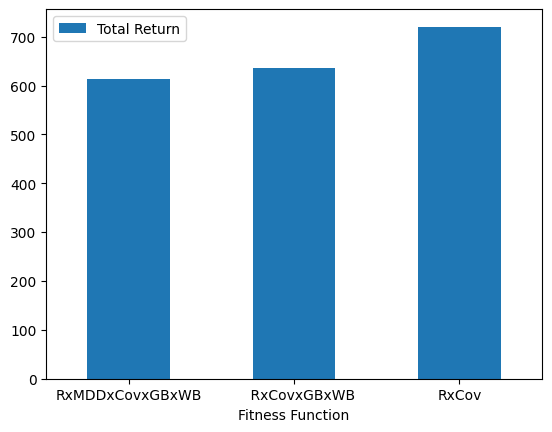

In [18]:
#Parrell Implementation return x cov
from multiprocessing import Pool 
import multiprocess as mp

def master_slave_r_cov(data,strategies,n_islands,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital):
    #lock.acquire()
    num_weight = (K*2) + 1
    population = init_population(pSize,n,b,K,num_weight,strategies)
    best = population[0]
    def fitness_func(island_chromosomes):
        for chromosome in island_chromosomes:
            fitness_function_2(chromosome,strategies,n,b,stop_loss,take_profit,allocated_capital,K)
        return island_chromosomes

    for j in range(n_iter):
        pool =mp.Pool(processes=n_islands)
        results =  [pool.apply(fitness_function_2, args=(i,strategies,n,b,stop_loss,take_profit,allocated_capital,K)) for i in population]
        #results =  pool.map(fitness_function, population)
        pool.close()
        pool.join()
        tempPopu  = selection(results)
        children = []
        #Crossover
        for i in range(0, len(tempPopu)-1, 2):

                # get selected parents in pairs
                parent1,parent2 = tempPopu[i],tempPopu[i+1]
                #crossover and mutation and inversion 
                child1,child2 = crossover(parent1,parent2,r_cross)
                child1 = mutation(child1, r_mut)
                child2 = mutation(child2, r_mut)
                child1 = inversion(child1, r_inv)
                child2 = inversion(child2, r_inv)
                children.append(child1)
                children.append(child2)
        population = children
        for chromosone in population:
                if chromosone[3] > best[3]:
                    best = chromosone
        

    return best
        
    

def main():
    #island_gga(queue,data,strategies,n_islands,m_iter,N,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
    data,strategies =  generate_candidate_trading_signals(aapl.copy())
    train_data = aapl[(aapl['Date'] <= datetime(2016,12,31))]
    test_data = aapl[(aapl['Date'] > datetime(2016,12,31))]
    test_data,st =  generate_candidate_trading_signals(test_data.copy())
    train_data,strategies =  generate_candidate_trading_signals(train_data.copy())
    n_islands = int(input("islands: "))
    K = int(input("K: "))
    pSize = int(input("popSize: "))
    r_cross = float(input("Cross over rate: "))
    r_mut = float(input("Mutation Rate: "))
    r_inv = float(input("Inversion Rate: "))
    n_iter = int(input("Number of Generations: "))
    n = int(input("SL: "))
    b = int(input("TP: "))
    stop_loss = float(input("Stop  Loss: "))
    take_profit = float(input("Take Profit: "))
    allocated_capital= float(input("Capital: "))
    r_cov_profit =[]
    no_mdd_profit=[]
    mdd_profit = []
    for i in range(50):
        mdd_chromosome = master_slave_with_mdd(train_data,strategies,n_islands,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
        no_mdd_chromosome = master_slave_no_mdd(train_data,strategies,n_islands,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
        r_cov_chromosome = master_slave_r_cov(train_data,strategies,n_islands,K,pSize,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
        print("DONE 1")
        no_mdd_performance = strategy_performance(test_data,strategies,no_mdd_chromosome[0],4,4,-0.15,.15)
        print("DONE 2")
        no_mdd_profit.append(getProfit(no_mdd_performance,no_mdd_chromosome,1000,3))
        mdd_performance = strategy_performance(test_data,strategies,mdd_chromosome[0],4,4,-0.15,.15)
        mdd_profit.append(getProfit(mdd_performance,mdd_chromosome,1000,3))
        r_cov_performance = strategy_performance(test_data,strategies,r_cov_chromosome[0],4,4,-0.15,.15)
        r_cov_profit.append(getProfit(r_cov_performance,r_cov_chromosome,1000,3))
    r_cov_profit = np.mean(r_cov_profit)
    no_mdd_profit=np.mean(no_mdd_profit)
    mdd_profit = np.mean(mdd_profit)
    print("DONE 3")
    cols = ["RxMDDxCovxGBxWB","    RxCovxGBxWB","RxCov"]
    df = pd.DataFrame({'Fitness Function':cols, 'Total Return':[mdd_profit,no_mdd_profit,r_cov_profit]})
    print("DONE 4")
    ax = df.plot.bar(x='Fitness Function', y='Total Return', rot=0)
if __name__ == "__main__":
    main()

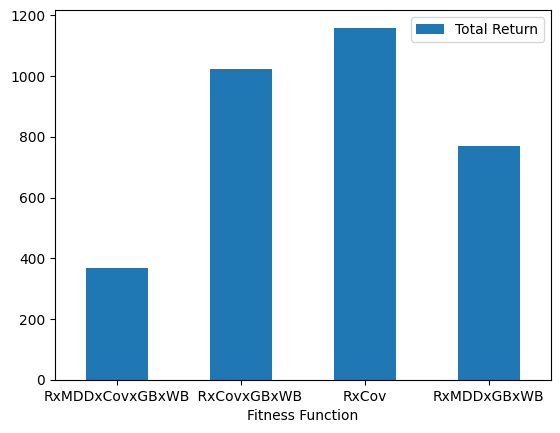

In [9]:
#gga(data,K,pSize,strategies,r_cross,r_mut,r_inv,n_iter,n,b,stop_loss,take_profit,allocated_capital)
#split data
train_data = aapl[(aapl['Date'] <= datetime(2016,12,31))]
test_data = aapl[(aapl['Date'] > datetime(2016,12,31))]
no_mdd_chromosome = [[0, 1, 1, 1, 0, 0, 1, 0], [['TS3_CONDITIONS', 'TS5_CONDITIONS', 'TS2_CONDITIONS', 'TS1_CONDITIONS', 'TS4_CONDITIONS', 'TS6_CONDITIONS', 'TS4_CONDITIONS'], ['TS1_CONDITIONS', 'TS7_CONDITIONS', 'TS5_CONDITIONS', 'TS8_CONDITIONS', 'TS4_CONDITIONS'], ['TS8_CONDITIONS', 'TS6_CONDITIONS', 'TS4_CONDITIONS', 'TS6_CONDITIONS', 'TS8_CONDITIONS', 'TS1_CONDITIONS']], [0, 1, 0, 0, 1, 1, 1], 116826.11164823678]
mdd_chromosome = [[1, 0, 0, 1, 0, 0, 1, 1], [['TS6_CONDITIONS', 'TS8_CONDITIONS', 'TS5_CONDITIONS', 'TS8_CONDITIONS', 'TS2_CONDITIONS', 'TS2_CONDITIONS', 'TS2_CONDITIONS'], ['TS4_CONDITIONS', 'TS3_CONDITIONS', 'TS7_CONDITIONS', 'TS3_CONDITIONS', 'TS8_CONDITIONS', 'TS4_CONDITIONS'], ['TS2_CONDITIONS', 'TS1_CONDITIONS', 'TS5_CONDITIONS', 'TS8_CONDITIONS', 'TS3_CONDITIONS']], [0, 1, 0, 1, 1, 0, 1], 62443.39718227137]
r_cov_chromosome = [[1, 0, 0, 0, 0, 0, 1, 0], [['TS4_CONDITIONS', 'TS3_CONDITIONS', 'TS7_CONDITIONS', 'TS2_CONDITIONS', 'TS8_CONDITIONS', 'TS8_CONDITIONS', 'TS5_CONDITIONS', 'TS8_CONDITIONS'], ['TS2_CONDITIONS', 'TS5_CONDITIONS', 'TS4_CONDITIONS', 'TS2_CONDITIONS', 'TS7_CONDITIONS', 'TS8_CONDITIONS'], ['TS6_CONDITIONS', 'TS1_CONDITIONS', 'TS8_CONDITIONS', 'TS2_CONDITIONS', 'TS6_CONDITIONS', 'TS8_CONDITIONS', 'TS2_CONDITIONS', 'TS4_CONDITIONS', 'TS2_CONDITIONS', 'TS2_CONDITIONS', 'TS2_CONDITIONS']], [0, 0, 0, 1, 1, 1, 1], 3292422.5847529094]
no_cov_chromosome = [[1, 0, 0, 1, 0, 0, 1, 1], [['TS2_CONDITIONS', 'TS3_CONDITIONS', 'TS4_CONDITIONS', 'TS6_CONDITIONS', 'TS6_CONDITIONS'], ['TS5_CONDITIONS', 'TS6_CONDITIONS', 'TS6_CONDITIONS'], ['TS8_CONDITIONS', 'TS7_CONDITIONS', 'TS1_CONDITIONS']], [1, 0, 1, 1, 1, 0, 1], 1246.638280303612]
train_data,strategies =  generate_candidate_trading_signals(train_data.copy())
no_mdd_performance = strategy_performance(train_data,strategies,no_mdd_chromosome[0],4,4,-0.15,.15)
no_mdd_profit =getProfit(no_mdd_performance,no_mdd_chromosome,1000,3)
mdd_performance = strategy_performance(train_data,strategies,mdd_chromosome[0],4,4,-0.15,.15)
mdd_profit =getProfit(mdd_performance,mdd_chromosome,1000,3)
r_cov_performance = strategy_performance(train_data,strategies,r_cov_chromosome[0],4,4,-0.15,.15)
r_cov_profit =getProfit(r_cov_performance,r_cov_chromosome,1000,3)
no_cov_performance = strategy_performance(train_data,strategies,no_cov_chromosome[0],4,4,-0.15,.15)
no_cov_profit =getProfit(no_cov_performance,no_cov_chromosome,1000,3)
#Buy and Hold Strategy Results
trade_return = (train_data.iloc[-1]['close'] - train_data.iloc[0]['close'])/train_data.iloc[0]['close'] 
HODL = round(trade_return ,2) *1000
# multiple lines with legend
cols = ["RxMDDxCovxGBxWB","    RxCovxGBxWB","RxCov","RxMDDxGBxWB"]
df = pd.DataFrame({'Fitness Function':cols, 'Total Return':[mdd_profit,no_mdd_profit,r_cov_profit,no_cov_profit]})
ax = df.plot.bar(x='Fitness Function', y='Total Return', rot=0)

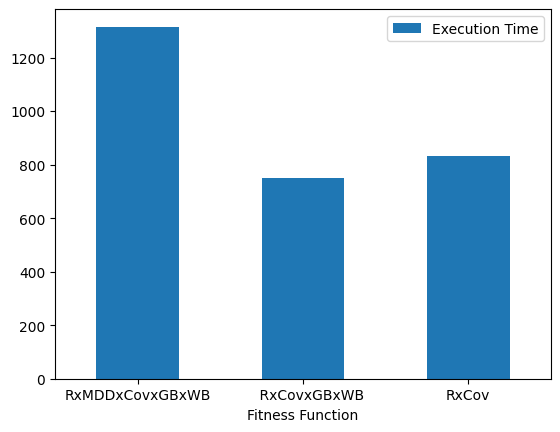

In [11]:
mdd_time =1315.3631031513214
no_mdd_time = 750.9618721008301
r_cov_time =830.5657353401184

cols = ["RxMDDxCovxGBxWB","    RxCovxGBxWB","RxCov"]
df = pd.DataFrame({'Fitness Function':cols, 'Execution Time':[mdd_time,no_mdd_time,r_cov_time]})
ax = df.plot.bar(x='Fitness Function', y='Execution Time', rot=0)